# Post-process model output

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from glob import glob
import yaml

import cftime

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

import cesm_tools

In [3]:
case = 'cam6327_sd.apo_test_srf_emis.003'

In [4]:
with open(f"caseinfo/{case}.yml") as fid:
    caseinfo = yaml.safe_load(fid)
    
srf_emis_files = caseinfo['srf_emis_files']    
archive_root = caseinfo['archive_root']    
sathist_fincl = caseinfo['sathist_fincl']    
archive_root

'/glade/scratch/mclong/archive/cam6327_sd.apo_test_srf_emis.003'

In [5]:
with xr.open_dataset(caseinfo['ncdata']) as ds:
    background_ppm = ds.attrs['cam_i_add_uniform_fields_background_ppm']
background_ppm

400.0

In [6]:
data_vars = list(srf_emis_files.keys()) + sathist_fincl
data_vars

['apo_jena',
 'co2_cesm',
 'co2_gridfed',
 'co2_oco2mip',
 'co2_somffn',
 'n2_cesm',
 'n2_era',
 'o2_cesm',
 'o2_gk01r16',
 'o2_gridfed',
 'T',
 'U',
 'V',
 'Q',
 'PS']

In [7]:
files = sorted(glob(f"{archive_root}/atm/hist/{case}.cam.hs.*.nc"))
[os.path.basename(f) for f in files]

['cam6327_sd.apo_test_srf_emis.003.cam.hs.2016-01-01-00000.nc',
 'cam6327_sd.apo_test_srf_emis.003.cam.hs.2016-01-18-70200.nc',
 'cam6327_sd.apo_test_srf_emis.003.cam.hs.2016-01-30-82800.nc']

In [8]:
cam_dsets = []
for f in files:
    with xr.open_dataset(f) as ds:
        cam_dsets.append(ds.load())

In [9]:
obspack_dir = "/glade/work/mclong/sno-analysis/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc"
campaign_keys = ["hip", "orc", "tom", "aoa"]

aircraft_files = {
    'hip': f"{obspack_dir}/co2_hip_aircraft-insitu_59_allvalid.nc",
    'orc': f"{obspack_dir}/co2_orc_aircraft-insitu_3_allvalid-merge10.nc",
    'tom': f"{obspack_dir}/co2_tom_aircraft-insitu_1_allvalid.nc",
    'aoa': f"{obspack_dir}/co2_aoa_aircraft-flask_19_allvalid.nc",
}

obspacks = {}
for key in campaign_keys:
    with xr.open_dataset(aircraft_files[key]) as dsi:
        dsi = dsi[['time', 'latitude', 'longitude', 'altitude', 'value']].load()
        
        for v in data_vars:
            dsi[v] = xr.full_like(dsi.value * cam_dsets[0].lev, fill_value=np.nan)
            dsi[v].attrs = cam_dsets[0][v].attrs
            
        dsi['model_time'] = xr.full_like(dsi.time, fill_value=np.nan)
        obspacks[key] = dsi

obspacks['orc']

<xarray.Dataset>
Dimensions:      (obs: 40217, lev: 56)
Coordinates:
  * lev          (lev) float64 1.868 2.353 2.948 3.677 ... 962.5 977.5 992.5
Dimensions without coordinates: obs
Data variables: (12/21)
    time         (obs) datetime64[ns] 2016-01-05T19:19:59 ... 2016-03-01T22:4...
    latitude     (obs) float32 39.92 39.91 39.92 39.92 ... 39.89 39.9 39.9 39.9
    longitude    (obs) float32 -105.0 -105.0 -105.1 ... -105.1 -105.1 -105.1
    altitude     (obs) float32 2.191e+03 2.194e+03 ... 1.733e+03 1.707e+03
    value        (obs) float32 0.000404 0.000404 ... 0.0004117 0.0004117
    apo_jena     (obs, lev) float64 nan nan nan nan nan ... nan nan nan nan nan
    ...           ...
    T            (obs, lev) float64 nan nan nan nan nan ... nan nan nan nan nan
    U            (obs, lev) float64 nan nan nan nan nan ... nan nan nan nan nan
    V            (obs, lev) float64 nan nan nan nan nan ... nan nan nan nan nan
    Q            (obs, lev) float64 nan nan nan nan nan ... nan nan nan nan nan
    PS           (obs, lev) float64 nan nan nan nan nan ... nan nan nan nan nan
    model_time   (obs) datetime64[ns] NaT NaT NaT NaT NaT ... NaT NaT NaT NaT
Attributes: (12/121)
    site_code:                                    ORC
    site_name:                                    ORCAS (O2/N2 Ratio and CO2 ...
    site_country:                                 Chile
    site_country_flag:                            CHIL0001.GIF
    site_latitude:                                -1e+34
    site_longitude:                               -1e+34
    ...                                           ...
    obspack_creation_date:                        2021-08-18T13:54:02.056239
    obspack_warning:                              Every effort is made to cre...
    obspack_fair_use:                             This cooperative data produ...
    obspack_usage_policy:                         www.gml.noaa.gov/ccgg/obspa...
    obspack_identifier_link:                      http://doi.org/10.25925/202...
    obspack_citation:                             Kenneth N. Schuldt, John Mu...

In [10]:
# loop over the sathist datasets
for ds in cam_dsets:
    # convert units
    for v in data_vars:
        if v in srf_emis_files:
            ds[v] = cesm_tools.tracegas_convert_units(
                ds[v],
                srf_emis_files[v]["constituent"],
                background_ppm=background_ppm,
            )

    # for each column in the dataset, find index into:
    # - the correct obspack file
    # - the correct index into that file
    for n in range(ds.sizes["ncol"]):
        # index the right ObsPack dataset
        obspack_key = campaign_keys[ds.orbit_num.values[n]]
        obspack = obspacks[obspack_key]
        i = ds.prof_num.values[n]
        for v in data_vars:
            obspack[v][i, :] = ds[v][n]

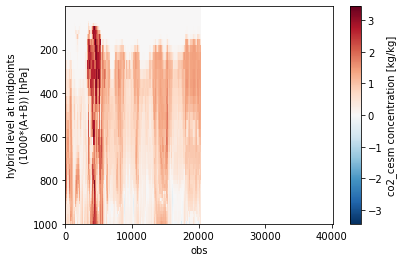

In [11]:
obspacks['orc'].co2_cesm.T.plot(yincrease=False);